## Font type Recognition using Logistic Regression

In [2]:
import tensorflow as tf
import numpy as np


In [3]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

In [4]:
# Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

### Data: 2790 36x36 images

In [5]:
train.shape

(2790, 36, 36)

In [6]:
# Look at some data
print(train[1])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [7]:
# If you have matplotlib installed
import matplotlib.pyplot as plt
%matplotlib inline

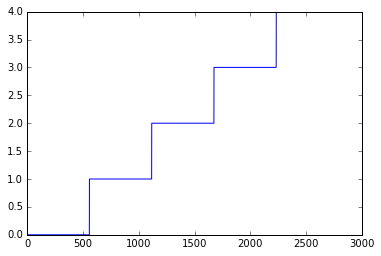

In [8]:
plt.plot(labels)

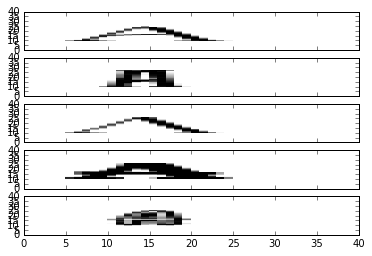

In [9]:
plt.ion()

# Let's look at a subplot of one of A in each font
f, plts = plt.subplots(5, sharex=True)
c = 90
for i in range(5):
    plts[i].pcolor(train[c + i * 558],
                   cmap=plt.cm.gray_r)

In [10]:
def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.
    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

In [11]:
print(onehot[600])

[ 0.  1.  0.  0.  0.]


### Permutation! + split data into training / validation

In [12]:
# Split data into training (90%) and validation (10%)
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
test, train = train[test_idx,:],\
              train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]

In [13]:
test.shape

(279, 36, 36)

In [14]:
onehot_test[0:4]

array([[ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.]])

In [15]:
sess = tf.InteractiveSession()


# These will be inputs
## Input pixels, flattened
x = tf.placeholder("float", [None, 1296])
## Known labels
y_ = tf.placeholder("float", [None,5])

# Variables
W = tf.Variable(tf.zeros([1296,5]))
b = tf.Variable(tf.zeros([5]))

# Just initialize
#sess.run(tf.initialize_all_variables())
sess.run(tf.global_variables_initializer())

# Define model
y = tf.nn.softmax(tf.matmul(x,W) + b)

### End model specification, begin training code


# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
        y + 1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


In [16]:
# Actually train
epochs = 1000

# aux arrays to store train and test accuracy results
# once every 10 epochs

train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)

for i in tqdm(range(epochs)):
    # Record summary data, and the accuracy
    if i % 10 == 0:
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={
            x: train.reshape([-1,1296]),
            y_: onehot_train})
        train_acc[i//10] = A
        # And now the validation set
        A = accuracy.eval(feed_dict={
            x: test.reshape([-1,1296]),
            y_: onehot_test})
        test_acc[i//10] = A
        
    # ALL data is used in every run (i.e. no minibatches)    
    train_step.run(feed_dict={
        x: train.reshape([-1,1296]),
        y_: onehot_train})


100%|██████████| 1000/1000 [00:26<00:00, 37.13it/s]


0.679808855057
0.648745536804


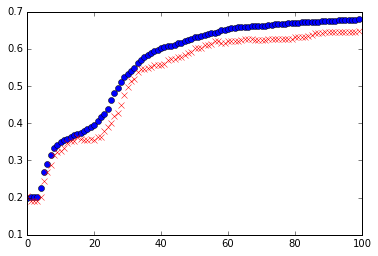

In [17]:
# Notice that accuracy flattens out
print(train_acc[-1])
print(test_acc[-1])

# Plot the accuracy curves
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')






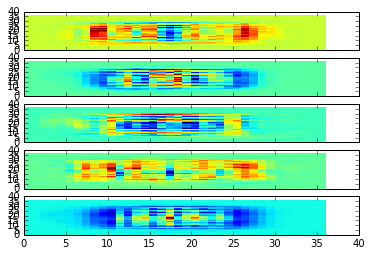

In [18]:
# Look at a subplot of the weights for each font
f, plts = plt.subplots(5, sharex=True)
for i in range(5):
    plts[i].pcolor(W.eval()[:,i].reshape([36,36]))